#  3D Phantom - Reduction

We reduce (or resample) the Magritte model of the 3D Phantom snapshot that was created in the [previous example](3_create_Phantom_3D.ipynb) using the methods explained in [De Ceuster et al. (2020)](https://ui.adsabs.harvard.edu/abs/2020MNRAS.499.5194D/abstract).

## Setup

Import the required functionalty.

In [1]:
import magritte.setup  as setup                        # Model setup
import magritte.core   as magritte                     # Core functionality
import magritte.mesher as mesher                       # Mesher
import numpy           as np                           # Data structures
import vtk                                             # Reading the model
import warnings                                        # Hide warnings
warnings.filterwarnings('ignore')                      # especially for yt
import yt                                              # 3D plotting
import os

from tqdm                   import tqdm                # Progress bars
from astropy                import constants           # Unit conversions
from vtk.util.numpy_support import vtk_to_numpy        # Converting data
from scipy.spatial          import Delaunay, cKDTree   # Finding neighbors
from yt.funcs               import mylog               # To avoid yt output 
mylog.setLevel(40)                                     # as error messages

Define a working directory (you will have to change this). We assume here that the scripts of the [previous example](3_create_Phantom_3D.ipynb) have already been executed and go back to that working directory.

In [2]:
wdir = "/home/frederik/Magritte-examples/Phantom_3D/"

Define file names.

In [3]:
model_file = os.path.join(wdir, 'model_Phantom_3D.hdf5')   # Original Magritte model
lamda_file = os.path.join(wdir, 'co.txt'               )   # Line data file
redux_file = os.path.join(wdir, 'model_Phantom_3D_red' )   # Reduced Magritte model (no extension!)

Load the original model.

In [4]:
model = magritte.Model(model_file)

                                           
-------------------------------------------
  Reading Model...                         
-------------------------------------------
 model file = /home/frederik/Magritte-examples/Phantom_3D/model_Phantom_3D.hdf5
-------------------------------------------
Reading parameters...
Reading points...
Reading rays...
Reading boundary...
Reading chemistry...
Reading species...
Reading thermodynamics...
Reading temperature...
Reading turbulence...
Reading lines...
Reading lineProducingSpecies...
Reading linedata...
read num 1
read sym CO
nlev = 41
nrad = 1
Reading collisionPartner...
Reading collisionPartner...
Reading quadrature...
Reading radiation...
Reading frequencies...
npoints = 1138671
nlines  = 1
nquads  = 31
Not using scattering!
                                           
-------------------------------------------
  Model read, parameters:                  
-------------------------------------------
  npoints    = 1138671
  nrays      = 2

Extract the data from the model by casting it into numpy arrays.

In [5]:
position = np.array(model.geometry.points.position)
velocity = np.array(model.geometry.points.velocity)
boundary = np.array(model.geometry.boundary.boundary2point)
nCO      = np.array(model.chemistry.species.abundance)[:,1]
nH2      = np.array(model.chemistry.species.abundance)[:,2]
tmp      = np.array(model.thermodynamics.temperature.gas)
trb      = np.array(model.thermodynamics.turbulence.vturb2)

Create a Delaunay mesh for the original points.

In [6]:
delaunay = Delaunay(position)

Define the radius for the (spherical) boundary of the reduced mesh ().

In [7]:
r_bdy = 0.99 * np.min(np.linalg.norm(position[boundary], axis=1))

Define a boundary for the the reduced mesh.

In [8]:
boundary_reduced = mesher.boundary_sphere(radius = r_bdy)

Create a reduced mesh with a sampling optimised for `nCO` (``%%capture`` suppresses the output).

In [9]:
%%capture
mesher.reduce(
    meshName  = redux_file,         # Name for reduced model
    delaunay  = delaunay,           # Delaunay object of original mesh
    tracer    = nCO,                # Tracer to optimise for sampling for
    boundary  = boundary_reduced,   # Boundary of reduced mesh
    scale_max = 1.0e+99,            # Maximum scale parameter
    scale_min = 0.0e+00,            # Minimum scale parameter
    threshold = 0.21,               # Threashold rel. diff. for coarsening
    fmin      = 1.0,                # Don't allow refinenment 
    ftarget   = 2.15                # 10^(-1/3) for approx 10x fewer points
)

Load the reducded mesh created above (a `.vtk` file with the same name as `redux_file`).

In [10]:
%%capture
mesh = mesher.Mesh(f'{redux_file}.vtk')

Compare the number of points in the original and the reduced mesh.

In [11]:
npoints          = model.parameters.npoints()
npoints_reduced  = len(mesh.points)

In [12]:
print('npoints original =', npoints)
print('npoints reduced  =', npoints_reduced)
print('reduction factor =', npoints/npoints_reduced)

npoints original = 1138671
npoints reduced  = 92207
reduction factor = 12.34907328077044


Interpolate the data to the reduced mesh. Effectively we find out which points in the original mesh are closes to which point in the reduced mesh and we simpliy map the data between the correpsonding points.

In [13]:
# Find closest points
corresp_points = cKDTree(position).query(mesh.points)[1]

# Map data
position_reduced = position[corresp_points]
velocity_reduced = velocity[corresp_points]
nCO_reduced      = nCO     [corresp_points]
nH2_reduced      = nH2     [corresp_points]
tmp_reduced      = tmp     [corresp_points]
trb_reduced      = trb     [corresp_points]

# Extract Delaunay vertices (= Voronoi neighbors)
delaunay = Delaunay(position_reduced)
(indptr, indices) = delaunay.vertex_neighbor_vertices
neighbors = [indices[indptr[k]:indptr[k+1]] for k in range(npoints_reduced)]
nbs       = [n for sublist in neighbors for n in sublist]
n_nbs     = [len(sublist) for sublist in neighbors]

# Convenience arrays
zeros = np.zeros(npoints_reduced)
ones  = np.ones (npoints_reduced)

Now we have all the data to construct the reduced Magritte model.

<div class="alert alert-warning">

Warning

Since we do not aim to do self-consistent non-LTE simulations in these examples, we only consider the first radiative transition of CO (J=1-0). To consider all transitions, use `setup.set_linedata_from_LAMDA_file` as in the commented line below it.

</div>

In [14]:
model = magritte.Model ()                                        # Create model object

model.parameters.set_model_name         (f'{redux_file}.hdf5')   # Magritte model file
model.parameters.set_spherical_symmetry (False)                  # No spherical symmetry
model.parameters.set_dimension          (3)                      # This is a 3D model
model.parameters.set_npoints            (npoints_reduced)        # Number of points
model.parameters.set_nrays              (2)                      # Number of rays  
model.parameters.set_nspecs             (5)                      # Number of species (min. 5)
model.parameters.set_nlspecs            (1)                      # Number of line species
model.parameters.set_nquads             (31)                     # Number of quadrature points
model.parameters.set_pop_prec           (1.0e-6)                 # Pops. convergence criterion

model.geometry.points.position.set(position_reduced)
model.geometry.points.velocity.set(velocity_reduced)

model.geometry.points.  neighbors.set(  nbs)
model.geometry.points.n_neighbors.set(n_nbs)

model.chemistry.species.abundance = np.array((zeros, nCO_reduced, nH2_reduced, zeros, ones)).T
model.chemistry.species.symbol    = ['dummy0', 'CO', 'H2', 'e-', 'dummy1']

model.thermodynamics.temperature.gas  .set(tmp_reduced)
model.thermodynamics.turbulence.vturb2.set(trb_reduced)

model.parameters.set_nboundary(len(mesh.boundary))
model.geometry.boundary.boundary2point.set(mesh.boundary)

model.geometry.rays.direction.set(np.array([[0,0,+1], [0,0,-1]]))
model.geometry.rays.weight   .set(np.array([  0.5   ,   0.5   ]))

model = setup.set_boundary_condition_CMB  (model)
model = setup.set_linedata_from_LAMDA_file(model, lamda_file, {'considered transitions': [0]})
# model = setup.set_linedata_from_LAMDA_file(model, lamda_file)   # Consider all transitions
model = setup.set_quadrature              (model)

model.write()

Not considering all radiative transitions on the data file but only the specified ones!
Writing parameters...
Writing rays...
Writing boundary...
Writing chemistry...
Writing species...
Writing thermodynamics...
Writing temperature...
Writing turbulence...
Writing lines...
Writing lineProducingSpecies...
Writing linedata...
ncolpoar = 2
--- colpoar = 0
Writing collisionPartner...
(l, c) = 0, 0
--- colpoar = 1
Writing collisionPartner...
(l, c) = 0, 1
Writing quadrature...
Writing populations...
Writing radiation...
Writing frequencies...


## Plot model

Load the data in a `yt` unstructured mesh.

In [15]:
ds = yt.load_unstructured_mesh(
         connectivity = mesh.tetras.astype(np.int64),
         coordinates  = mesh.points.astype(np.float64) * 100.0, # yt expects cm not m
         node_data    = {('connect1', 'n'): nCO_reduced[mesh.tetras].astype(np.float64)}
)

Plot a slice through the mesh orthogonal to the z-axis.


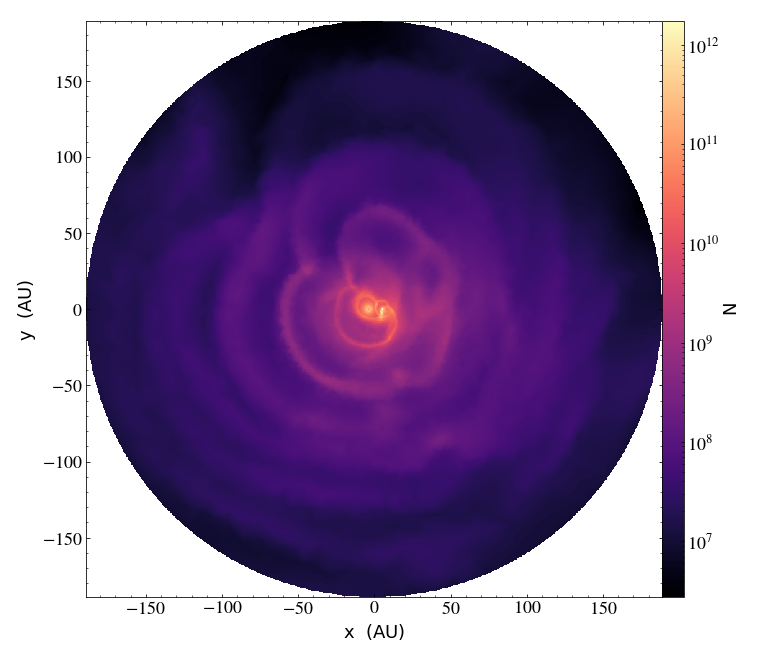

In [16]:
sl = yt.SlicePlot (ds, 'z', 'n')
sl.set_cmap       ('n', 'magma')
sl.zoom           (1.1)

Show mesh on the plot.


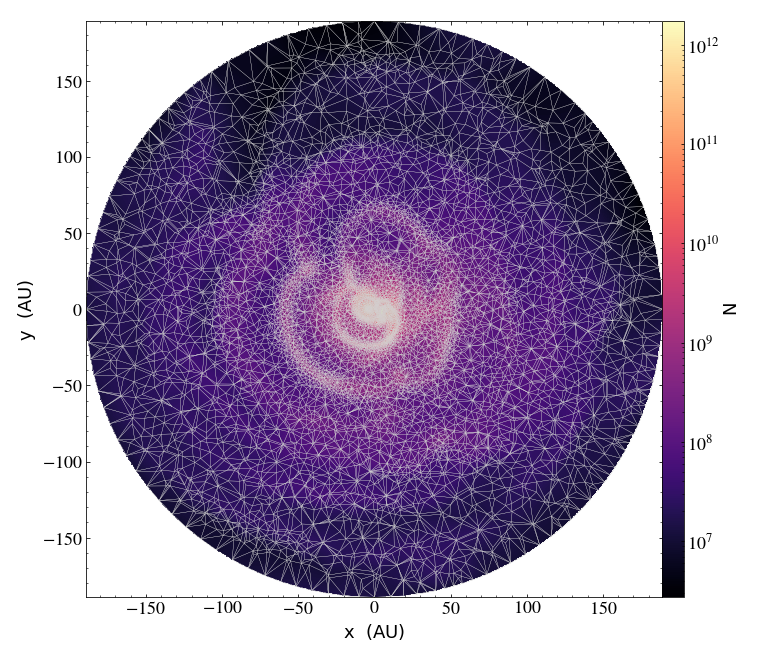

In [17]:
sl = yt.SlicePlot      (ds, 'z', 'n')
sl.set_cmap            ('n', 'magma')
sl.zoom                (1.1)
sl.annotate_mesh_lines (plot_args={'color':'lightgrey', 'linewidths':[.25]})